# AD ASTRA Collision tracking

In [1]:
# Uncomment the below lines and run the cell before executing, comment it out after all installs are done

# !pip install --upgrade pip
# !pip install sgp4
# !pip install numpy
# !pip install spacetrack
# !pip install asyncio
# !pip install skyfield
# !pip install matplotlib



In [2]:
# Time to do all the imports
from spacetrack import SpaceTrackClient
from skyfield.api import Loader, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json


In [3]:
# Lets collect some trash!
from spacetrack import SpaceTrackClient
import json

st = SpaceTrackClient('email.jrv@gmail.com', 'cyQgit-mapci5-dotrif') # everyone should not run this at once lol
trash = st.tle_latest( object_type='debris', ordinal=1, format='json', orderby='norad_cat_id' ) # TODO : Stream this stuff, choose fewer elements
trash_dict = json.loads(trash)

Now we define helper functions for plotting orbits from the data

In [49]:
def makecubelimits(ax, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw

In [63]:
def make_orbit(L1, L2, hours):
    Roadster = EarthSatellite(L1, L2)
    print(Roadster.epoch.tt)
    time = ts.utc(2018, 2, 7, hours)
    Rpos    = Roadster.at(time).position.km
    Rposecl = Roadster.at(time).ecliptic_position().km
    re = 6378. # Radius of the Earth
    theta = np.linspace(0, twopi, 201)
    cth, sth, zth = [f(theta) for f in [np.cos, np.sin, np.zeros_like]]
    lon0 = re*np.vstack((cth, zth, sth))
    lons = []
    for phi in rads*np.arange(0, 180, 15):
        cph, sph = [f(phi) for f in [np.cos, np.sin]]
        lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                        lon0[1]*cph + lon0[0]*sph,
                        lon0[2]) )
        lons.append(lon)

    # lat0 = re*np.vstack((cth, sth, zth))
    lats = []
    for phi in rads*np.arange(-75, 90, 15):
        cph, sph = [f(phi) for f in [np.cos, np.sin]]
        lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
        lats.append(lat)

    return Rpos,Rposecl, lats, lons

def plot_orbit( ax, Rpos, lons, lats, i ):
    
    x, y, z = Rpos
    
    for j in range(Rpos[0].shape[0]):
        r = 100
        u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
        p = np.cos(u) * np.sin(v) + x[j]
        q = np.sin(u) * np.sin(v) + y[j]
        r = np.cos(v) + z[j]
        ax.plot_surface(p, q, r, cmap=plt.cm.YlGnBu_r,  alpha=0.1)

    # ax.plot(x, y, z, label='Debris '+ str(i) ) # Plot the orbit

    # centers, hw = makecubelimits(ax)
    # print("centers are: ", centers)
    # print("hw is:       ", hw)

## Create a View that can be moved  
(Depending on the jupyter notebook inplementation, this might not work for akk)

In [64]:
def move_view(event):
    ax.autoscale(enable=False, axis='both') 
    koef = 8
    zkoef = (ax.get_zbound()[0] - ax.get_zbound()[1]) / koef
    xkoef = (ax.get_xbound()[0] - ax.get_xbound()[1]) / koef
    ykoef = (ax.get_ybound()[0] - ax.get_ybound()[1]) / koef
    ## Map an motion to keyboard shortcuts
    if event.key == "ctrl+down":
        ax.set_ybound(ax.get_ybound()[0] + xkoef, ax.get_ybound()[1] + xkoef)
    if event.key == "ctrl+up":
        ax.set_ybound(ax.get_ybound()[0] - xkoef, ax.get_ybound()[1] - xkoef)
    if event.key == "ctrl+right":
        ax.set_xbound(ax.get_xbound()[0] + ykoef, ax.get_xbound()[1] + ykoef)
    if event.key == "ctrl+left":
        ax.set_xbound(ax.get_xbound()[0] - ykoef, ax.get_xbound()[1] - ykoef)
    if event.key == "down":
        ax.set_zbound(ax.get_zbound()[0] - zkoef, ax.get_zbound()[1] - zkoef)
    if event.key == "up":
        ax.set_zbound(ax.get_zbound()[0] + zkoef, ax.get_zbound()[1] + zkoef)
    # zoom option
    if event.key == "alt+up":
        ax.set_xbound(ax.get_xbound()[0]*0.90, ax.get_xbound()[1]*0.90)
        ax.set_ybound(ax.get_ybound()[0]*0.90, ax.get_ybound()[1]*0.90)
        ax.set_zbound(ax.get_zbound()[0]*0.90, ax.get_zbound()[1]*0.90)
    if event.key == "alt+down":
        ax.set_xbound(ax.get_xbound()[0]*1.10, ax.get_xbound()[1]*1.10)
        ax.set_ybound(ax.get_ybound()[0]*1.10, ax.get_ybound()[1]*1.10)
        ax.set_zbound(ax.get_zbound()[0]*1.10, ax.get_zbound()[1]*1.10)
    
    # Rotational movement
    elev=ax.elev
    azim=ax.azim
    if event.key == "shift+up":
        elev+=10
    if event.key == "shift+down":
        elev-=10
    if event.key == "shift+right":
        azim+=10
    if event.key == "shift+left":
        azim-=10

    ax.view_init(elev= elev, azim = azim)
    # print which ever variable you want 
    ax.figure.canvas.draw()

/var/folders/f3/kpczkdnn3j55cz0dcsb0066w0000gn/T/ipykernel_1028/1333913967.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


2437213.8332023206
2437374.159316971


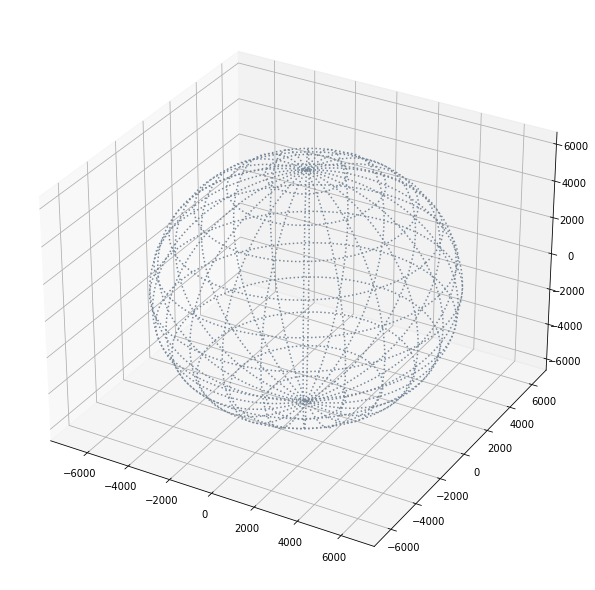

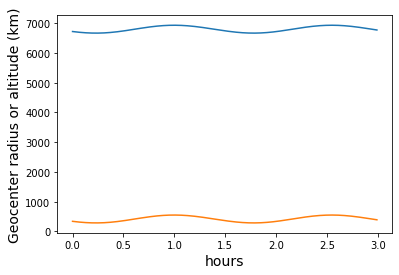

In [65]:
# Lets viz three orbits
# L1 = trash_dict[0]['TLE_LINE1']
# L2 = trash_dict[0]['TLE_LINE2']...and so on

halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
degs, rads = 180/pi, pi/180
SHOW_ALTITUDE = True
SHOW_ORBIT = True

load = Loader('~/MyStuff/SpaceApps/Ad_Astra_Tracking_System')
data = load('de421.bsp')
ts   = load.timescale()
planets = load('de421.bsp')
earth   = planets['earth']
hours = np.arange(0, 3, 0.01)


fig = plt.figure(figsize=[10, 8])  # [12, 10]
ax = Axes3D(fig)
# ax  = fig.add_subplot(1, 1, 1, projection='3d')

for i in range (2):
    Rpos, Rposecl, lats, lons = make_orbit(trash_dict[i]['TLE_LINE1'], trash_dict[i]['TLE_LINE2'], hours)
    
    if i == 0:
        for x, y, z in lons:
            ax.plot(x, y, z, color='lightslategrey', linestyle='dotted', label='Debris '+ str(i))
        for x, y, z in lats:
            ax.plot(x, y, z,  color='lightslategrey',linestyle='dotted', label='Debris '+ str(i))
            
    if SHOW_ORBIT == True:    
        plot_orbit( ax, Rpos, lons, lats, i )

fig.canvas.mpl_connect("key_press_event", move_view)        
plt.show()

r_Roadster = np.sqrt((Rpos**2).sum(axis=0))
alt_roadster = r_Roadster - 6378. # Radius of the Earth

if SHOW_ALTITUDE == True:
    plt.figure()
    plt.plot(hours, r_Roadster)
    plt.plot(hours, alt_roadster)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()